In [1]:
import pandas as pd
import numpy as np
import random
from data_reader import MaldiDataset
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, precision_recall_fscore_support
from preprocessing_components import ColumnDropper, SpectrumExpander, IntensityScaler, TICLogTransformer
from sklearn.calibration import LabelEncoder
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import joblib

# Carga de datos

In [2]:
random.seed(42)
np.random.seed(42)


# This script is a simple starting point to classify fungal data using MALDI-TOF spectra.
class SimpleFungusDataLoader:
    def __init__(self, dataset_path, test_size=0.2, random_state=42):
        # Initialize the classifier with dataset path, test size, and random state for reproducibility.
        self.dataset_path = dataset_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.train_data = []
        self.test_data = []

    def load_data(self, n_step):
        # Load the dataset using MaldiDataset
        dataset = MaldiDataset(self.dataset_path, n_step=n_step)
        dataset.parse_dataset()  # Parse the dataset from the specified path
        self.data = dataset.get_data()  # Retrieve the parsed data


    def split_data_stratify(self):
        """
        Divide los datos en train y test de forma estratificada según 'genus_species_label',
        asegurando que no haya solapamiento de 'unique_id_label' entre ambos conjuntos.
        Las clases con menos de 2 instancias se asignan directamente al conjunto de entrenamiento.
        """
        # Convertir los datos en un DataFrame
        df = pd.DataFrame(self.data)

        # Agrupar por 'unique_id_label' y seleccionar una clase representativa ('genus_species_label') para cada grupo
        unique_id_groups = df.groupby('unique_id_label').first().reset_index()

        # Identificar las clases con menos de 2 instancias
        class_counts = unique_id_groups['genus_species_label'].value_counts()
        small_classes = class_counts[class_counts < 2].index

        # Separar los grupos con clases pequeñas y el resto
        small_class_groups = unique_id_groups[unique_id_groups['genus_species_label'].isin(small_classes)]
        remaining_groups = unique_id_groups[~unique_id_groups['genus_species_label'].isin(small_classes)]

        # Estratificar las clases restantes
        train_ids, test_ids = train_test_split(
            remaining_groups['unique_id_label'],
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=remaining_groups['genus_species_label']  # Usar 'genus_species_label' como criterio de estratificación
        )

        # Agregar todas las instancias de clases pequeñas al conjunto de entrenamiento
        train_ids = pd.concat([pd.Series(train_ids), small_class_groups['unique_id_label']])

        # Filtrar el DataFrame original para crear los conjuntos de train y test
        self.train_data = df[df['unique_id_label'].isin(train_ids)]  # DataFrame de entrenamiento
        self.test_data = df[df['unique_id_label'].isin(test_ids)]  # DataFrame de prueba

        # Verificar que no haya solapamiento de 'unique_id_label' entre train y test
        train_unique_ids = set(self.train_data['unique_id_label'])
        test_unique_ids = set(self.test_data['unique_id_label'])
        assert len(train_unique_ids.intersection(test_unique_ids)) == 0, "Unique ID labels overlap between train and test"

        # Imprimir estadísticas
        print(f"Number of unique_id_labels in train data: {len(train_unique_ids)}")
        print(f"Number of unique_id_labels in test data: {len(test_unique_ids)}")
        print(f"Number of samples in train data: {len(self.train_data)}")
        print(f"Number of samples in test data: {len(self.test_data)}")
        print(f"Number of classes to predict: {len(self.train_data['genus_species_label'].unique())}")



    def plot_data_distribution(self):
        """
        Grafica la distribución de las clases ('genus_species_label') en los conjuntos de
        entrenamiento y prueba para visualizar las proporciones después de la división estratificada.
        """
        # Contar las etiquetas en los conjuntos de entrenamiento y prueba
        train_counts = self.train_data['genus_species_label'].value_counts()
        test_counts = self.test_data['genus_species_label'].value_counts()

        # Unificar las etiquetas para asegurar que ambas series tengan los mismos índices
        all_labels = pd.Index(train_counts.index).union(test_counts.index)
        train_counts = train_counts.reindex(all_labels, fill_value=0)
        test_counts = test_counts.reindex(all_labels, fill_value=0)

        # Crear gráfico
        x = np.arange(len(all_labels))  # Posiciones de las barras
        width = 0.4  # Ancho de las barras

        plt.figure(figsize=(14, 8))  # Tamaño del gráfico
        plt.bar(x - width / 2, train_counts, width, label='Train', alpha=0.8, color='blue')
        plt.bar(x + width / 2, test_counts, width, label='Test', alpha=0.8, color='orange')

        # Configurar etiquetas y título
        plt.xlabel('Genus+Species Label', fontsize=12)
        plt.ylabel('Number of Samples', fontsize=12)
        plt.title('Distribution of Genus+Species Labels in Train and Test Data', fontsize=14)
        plt.xticks(x, all_labels, rotation=90, fontsize=10)  # Etiquetas en el eje X
        plt.legend(fontsize=12)

        # Ajustar diseño
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    def get_train_data(self):
        return self.train_data
    
    def get_test_data(self):
        return self.test_data

In [3]:
# Define the dataset path (update this path to where your dataset is located)
dataset_path = "data/fungus_db"

# Initialize the classifier with the dataset path
fungus_identifier = SimpleFungusDataLoader(dataset_path)

# Cargar los datos usando n_step=3 para 3 bins
fungus_identifier.load_data(n_step=3)

# Load and split the data into training and test sets.
fungus_identifier.split_data_stratify()

c:\Users\aleta\Documents\TFM\FungusClassifier\data_reader.py:299: RuntimeWarning: invalid value encountered in divide
  intensity=SpectrumObj.intensity / SpectrumObj.intensity.sum() * self.sum,


Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Number of unique_id_labels in train data: 268
Number of unique_id_labels in test data: 64
Number of samples in train data: 6452
Number of samp

In [5]:
genus_species_critical = [
    'Candida auris', 
    'Cryptococcus neoformans', 
    'Aspergillus fumigatus'
]
genus_species_high = [
    'Mucor circinelloides', 
    'Fusarium anthophilium', 
    'Fusarium dimerum'
    'Fusarium faciforme',
    'Fusarium fujikuorii',
    'Fusarium keratoplasticum',
    'Fusarium oxysporum',
    'Fusarium petroliphilum',
    'Fusarium proliferatum',
    'Fusarium solani',
    'Fusarium verticillioides',
]
species_list = [
        'Aspergillus alliaceus',
        'Aspergillus awamori',
        'Aspergillus calidoustus',
        'Aspergillus citrinoterreus',
        'Aspergillus felis-viridinutans',
        'Aspergillus flavus',
        'Aspergillus fumigatus',
        'Aspergillus lentulus',
        'Aspergillus melleus',
        'Aspergillus nidulans',
        'Aspergillus niger',
        'Aspergillus nomiae',
        'Aspergillus novofumigatus',
        'Aspergillus parasiticus',
        'Aspergillus persii',
        'Aspergillus pseudodeflectus',
        'Aspergillus subramanianii',
        'Aspergillus sydowii',
        'Aspergillus tamarii',
        'Aspergillus terreus',
        'Aspergillus thermomutatus',
        'Aspergillus viridinutans',
        'Candida auris',
        'Cryptococcus neoformans',
        'Cunninghamella bertholletiae',
        'Emericella nidulans',
        'Exophiala oligoesperma',
        'Fusarium anthophilium',
        'Fusarium dimerum',
        'Fusarium faciforme',
        'Fusarium fujikuorii',
        'Fusarium keratoplasticum',
        'Fusarium oxysporum',
        'Fusarium petroliphilum',
        'Fusarium proliferatum',
        'Fusarium solani',
        'Fusarium verticillioides',
        'Hyphozyma variabilis',
        'Lichtheimia corymbifera',
        'Lichtheimia ramosa',
        'Microsporum audouinii',
        'Microsporum canis',
        'Mucor circinelloides',
        'Neosartorya fischeri',
        'Neosartorya fisheri',
        'Neosartorya tsurutae',
        'Neosartorya udagawae',
        'Pseudallescheria boydii',
        'Rhizomucor pusillus',
        'Rhizopus arrhizus',
        'Rhizopus microsporus',
        'Scedosporium apiospermum',
        'Scedosporium prolificans',
        'Syncephalastrum sp.',
        'Trichophyton benhamiae',
        'Trichophyton concentricum',
        'Trichophyton interdigitale',
        'Trichophyton japonicum',
        'Trichophyton rubrum',
        'Trichophyton tonsurans'
    ]

critical_species_labels = [22, 23, 6]
high_risk_species_labels = [42, 32, 33, 34, 35, 36]

genus_critical = [
    'Candida', 
    'Cryptococcus', 
    'Aspergillus'
]
genus_high = [
    'Mucor', 
    'Fusarium'
]
genus_list = [
        "Aspergillus",
        "Candida",
        "Cryptococcus",
        "Cunninghamella",
        "Emericella",
        "Exophiala",
        "Fusarium",
        "Hyphozyma",
        "Lichtheimia",
        "Microsporum",
        "Mucor",
        "Neosartorya",
        "Pseudallescheria", 
        "Rhizomucor",
        "Rhizopus",
        "Scedosporium",
        "Syncephalastrum",
        "Trichophyton"
    ]

critical_genus_labels = [0,1,2]
high_risk_genus_labels = [6,10]

In [6]:
train_data = fungus_identifier.get_train_data()
test_data = fungus_identifier.get_test_data()
print(f"Test data shape: {test_data.shape}")
print(f"Train data shape: {train_data.shape}")

Test data shape: (1476, 5)
Train data shape: (6452, 5)


In [7]:
label_encoder_genus_species = LabelEncoder()
label_encoder_genus = LabelEncoder()
x_train = train_data.drop(columns=['genus_species_label', 'genus_label'])
y_species_train = label_encoder_genus_species.fit_transform(train_data['genus_species_label'])
y_genus_train = label_encoder_genus.fit_transform(train_data['genus_label'])
x_test = test_data.drop(columns=['genus_species_label', 'genus_label'])
y_species_test = label_encoder_genus_species.transform(test_data['genus_species_label'])
y_genus_test = label_encoder_genus.transform(test_data['genus_label'])

# Métodos de evaluación

## Métodos de evaluación a nivel de género y especie

In [8]:
def evaluate_species_classifier(
    y_true, 
    y_pred, 
    critical_species_labels=None, 
    high_risk_species_labels=None, 
    class_names=None, 
    title='Classification Results', 
    crifigsize=(14, 12),
    highlight_background=True
):
    """
    Evalúa el rendimiento de un clasificador de especies y dibuja la matriz de confusión.
    
    Si se proporcionan las listas critical_species_labels y/o high_risk_species_labels y
    highlight_background=True, se colorearán las filas correspondientes 
    (hongos críticos en color pastel rojo y alto riesgo en color pastel amarillo) y se añadirá una leyenda.
    
    Si highlight_background=False (por ejemplo, al invocar desde métodos especializados), 
    se dibuja una matriz "normal" usando un colormap suave en escala de grises, 
    sin fondo coloreado ni leyenda.
    
    Parámetros:
      - y_true: Etiquetas verdaderas.
      - y_pred: Etiquetas predichas.
      - critical_species_labels: Lista de etiquetas (números) de hongos críticos.
      - high_risk_species_labels: Lista de etiquetas de hongos de alto riesgo.
      - class_names: Lista de nombres de clases para la visualización.
      - title: Título de la evaluación.
      - crifigsize: Tamaño de la figura.
      - highlight_background: Booleano que indica si se pinta el fondo (y se añade leyenda) o no.
      
    Retorna:
      dict con las métricas y la matriz de confusión.
    """
    # Convertir a numpy array si es DataFrame
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values.ravel()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values.ravel()

    # Métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    # Nombres de clases por defecto, si no se suministran
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(np.concatenate([y_true, y_pred]))))]

    # Determinar las clases presentes en esta evaluación
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    class_name_mapping = {i: name for i, name in enumerate(class_names)}
    filtered_class_names = [class_name_mapping[i] for i in unique_classes if i < len(class_names)]
    
    # Reporte de clasificación
    report_text = classification_report(y_true, y_pred, target_names=filtered_class_names, zero_division=0)
    report_dict = classification_report(y_true, y_pred, target_names=filtered_class_names, output_dict=True, zero_division=0)

    # Imprimir resultados
    print(f"\n{title}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report_text)
    
    # Iniciar figura y ejes
    fig, ax = plt.subplots(figsize=crifigsize)

    # -------------------------------------------------------------------
    # Opción 1: Con fondo coloreado según especies críticas/alto riesgo
    # -------------------------------------------------------------------
    if highlight_background:
        mark_critical = (critical_species_labels is not None)
        mark_high_risk = (high_risk_species_labels is not None)

        critical_labels = critical_species_labels if mark_critical else []
        high_risk_labels = high_risk_species_labels if mark_high_risk else []

        # Índices de cada grupo (en las filas de la CM)
        critical_rows = [i for i, lbl in enumerate(unique_classes) if lbl in critical_labels]
        high_risk_rows = [i for i, lbl in enumerate(unique_classes) if lbl in high_risk_labels]

        # Crear matriz "bg" para fondo: 0=fila normal, 1=alto riesgo, 2=críticos
        bg = np.zeros_like(cm, dtype=int)
        for i in range(bg.shape[0]):
            if mark_critical and i in critical_rows:
                bg[i, :] = 2
            elif mark_high_risk and i in high_risk_rows:
                bg[i, :] = 1

        # Definir colormap pastel: 0->blanco, 1->amarillo pastel, 2->rojo pastel
        cmap_bg = mcolors.ListedColormap(["white", "#fff9c4", "#ffcccc"])
        sns.heatmap(
            bg,
            cmap=cmap_bg,
            cbar=False,
            square=True,
            linewidths=0.5,
            linecolor='gray',
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names,
            ax=ax
        )

        # Agregar leyenda si hay filas marcadas
        legend_handles = []
        if mark_critical:
            red_patch = mpatches.Patch(color="#ffcccc", label='Critical Species')
            legend_handles.append(red_patch)
        if mark_high_risk:
            yellow_patch = mpatches.Patch(color="#fff9c4", label='High Risk Species')
            legend_handles.append(yellow_patch)
        if legend_handles:
            plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    # -------------------------------------------------------------------
    # Opción 2: Sin fondo coloreado, usar un colormap suave en escala de grises
    # -------------------------------------------------------------------
    else:
        cm_df = pd.DataFrame(
            cm,
            index=[class_name_mapping[i] for i in unique_classes],
            columns=[class_name_mapping[i] for i in unique_classes]
        )

        # Definir un colormap gris claro
        cmap_custom = mcolors.LinearSegmentedColormap.from_list(
            "CustomGreys",
            ["#ffffff", "#f2f2f2", "#e0e0e0", "#cccccc", "#b3b3b3", "#999999"],
            N=256
        )

        sns.heatmap(
            cm_df,
            annot=False,  # Solo dibujamos fondo aquí, los valores van luego con ax.text
            fmt='d',
            cmap=cmap_custom,
            linewidths=0.5,
            linecolor='gray',
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names,
            ax=ax
        )

    # -------------------------------------------------------------------
    # Superponer valores de la matriz de confusión con su color
    # -------------------------------------------------------------------
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            # Texto en negro si value==0, verde en diagonal (>0), rojo fuera diagonal (>0)
            if value == 0:
                text_color = 'black'
            else:
                text_color = 'green' if i == j else 'red'

            ax.text(
                j + 0.5, 
                i + 0.5,
                str(value),
                ha='center',
                va='center',
                color=text_color,
                fontsize=9,
                fontweight='bold'
            )

    # Etiquetas y formateo
    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted Fungi')
    ax.set_ylabel('True Fungi')
    ax.set_xticks(np.arange(cm.shape[1]) + 0.5)
    ax.set_yticks(np.arange(cm.shape[0]) + 0.5)
    ax.set_xticklabels(filtered_class_names, rotation=45, ha='right')
    ax.set_yticklabels(filtered_class_names, rotation=0)

    plt.tight_layout()
    plt.show()

    # Retornar resultados
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'confusion_matrix': cm,
        'report': report_dict
    }


In [9]:
def evaluate_classifier_in_critical_species(y_true, y_pred, critical_species_labels, class_names=None):
    """
    Evalúa un clasificador únicamente en aquellas especies que se consideran críticas,
    incluyendo tanto muestras que son realmente de especies críticas como aquellas
    que fueron predichas como especies críticas.
    Destaca con color rojo las filas correspondientes a especies críticas.
    """
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values.ravel()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values.ravel()
    
    # Seleccionar muestras donde la etiqueta verdadera O la predicción están en especies críticas
    mask = np.logical_or(np.isin(y_true, critical_species_labels), np.isin(y_pred, critical_species_labels))
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return evaluate_species_classifier(y_true_filtered, y_pred_filtered, critical_species_labels=critical_species_labels, class_names=class_names, title='Critical Species Evaluation', highlight_background=True)

In [10]:
def evaluate_classifier_in_high_risk_species(y_true, y_pred, high_risk_species_labels, class_names=None):
    """
    Evalúa un clasificador únicamente en aquellas especies que se consideran de alto riesgo,
    incluyendo tanto muestras que son realmente de especies de alto riesgo como aquellas
    que fueron predichas como especies de alto riesgo.
    Destaca con color amarillo las filas correspondientes a especies de alto riesgo.
    """
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values.ravel()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values.ravel()
    
    # Seleccionar muestras donde la etiqueta verdadera O la predicción están en especies de alto riesgo
    mask = np.logical_or(np.isin(y_true, high_risk_species_labels), np.isin(y_pred, high_risk_species_labels))
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return evaluate_species_classifier(y_true_filtered, y_pred_filtered, high_risk_species_labels=high_risk_species_labels, class_names=class_names, title='High Risk Species Evaluation', highlight_background=True)

## Métodos de evaluación a nivel de género

In [11]:
def evaluate_genus_classifier(y_true, y_pred, critical_genus_labels=None, high_risk_genus_labels=None, 
                              class_names=None, title='Classification Results', crifigsize=(14, 12),
                              highlight_background=True):
    """
    Evalúa el rendimiento de un clasificador a nivel de género y dibuja la matriz de confusión.
    
    - Si se proporcionan las listas critical_genus_labels y/o high_risk_genus_labels y
      highlight_background=True, se colorearán las filas correspondientes (géneros críticos en color pastel rojo 
      y géneros de alto riesgo en color pastel amarillo) y se añadirá una leyenda.
    - Si highlight_background=False, se dibuja una matriz "normal" sin fondo coloreado ni leyenda,
      utilizando una escala de grises ("Greys").
    
    Parámetros:
      - y_true: Etiquetas verdaderas.
      - y_pred: Etiquetas predichas.
      - critical_genus_labels: Lista de etiquetas (números) de géneros críticos.
      - high_risk_genus_labels: Lista de etiquetas (números) de géneros de alto riesgo.
      - class_names: Lista de nombres de clases para la visualización.
      - title: Título de la evaluación.
      - crifigsize: Tamaño de la figura.
      - highlight_background: Booleano que indica si se pinta el fondo (y se añade leyenda) o no.
      
    Retorna:
      dict con las métricas y la matriz de confusión.
    """
    # Convertir a numpy array si es DataFrame
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values.ravel()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values.ravel()

    # Métricas básicas
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    # Nombres de clases por defecto, si no se suministran
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(np.concatenate([y_true, y_pred]))))]

    # Determinar las clases presentes en esta evaluación
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    class_name_mapping = {i: name for i, name in enumerate(class_names)}
    filtered_class_names = [class_name_mapping[i] for i in unique_classes if i < len(class_names)]
    
    # Reporte de clasificación
    report_text = classification_report(y_true, y_pred, target_names=filtered_class_names, zero_division=0)
    report_dict = classification_report(y_true, y_pred, target_names=filtered_class_names, output_dict=True, zero_division=0)

    # Imprimir resultados
    print(f"\n{title}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report_text)
    
    # Iniciar figura y eje
    fig, ax = plt.subplots(figsize=crifigsize)

    if highlight_background:
        # Verificar si se deben colorear filas según las listas proporcionadas
        mark_critical = (critical_genus_labels is not None)
        mark_high_risk = (high_risk_genus_labels is not None)

        critical_labels = critical_genus_labels if mark_critical else []
        high_risk_labels = high_risk_genus_labels if mark_high_risk else []

        # Determinar los índices en la matriz de confusión para cada grupo
        critical_rows = [i for i, label in enumerate(unique_classes) if label in critical_labels]
        high_risk_rows = [i for i, label in enumerate(unique_classes) if label in high_risk_labels]

        # Crear "background" para colorear filas:
        # 0: fila normal, 1: fila de alto riesgo, 2: fila crítica.
        bg = np.zeros_like(cm, dtype=int)
        for i in range(bg.shape[0]):
            if mark_critical and (i in critical_rows):
                bg[i, :] = 2  # Género crítico: color pastel rojo
            elif mark_high_risk and (i in high_risk_rows):
                bg[i, :] = 1  # Género de alto riesgo: color pastel amarillo

        # Definir colormap: 0 -> blanco, 1 -> pastel amarillo, 2 -> pastel rojo
        colors = ["white", "#fff9c4", "#ffcccc"]
        cmap_bg = mcolors.ListedColormap(colors)

        # Primera capa: fondo coloreado según "bg"
        sns.heatmap(
            bg,              
            cmap=cmap_bg,    
            cbar=False,      
            square=True,
            linewidths=0.5,
            linecolor='gray',
            xticklabels=filtered_class_names, 
            yticklabels=filtered_class_names, 
            ax=ax
        )
    else:
        # Sin fondo coloreado: dibujar la matriz de confusión normal en escala de grises
        cm_df = pd.DataFrame(
            cm, 
            index=[class_name_mapping[i] for i in unique_classes],
            columns=[class_name_mapping[i] for i in unique_classes]
        )
        sns.heatmap(cm_df, annot=False, fmt='d', cmap="Greys", 
                    linewidths=0.5, linecolor='gray', 
                    xticklabels=filtered_class_names, 
                    yticklabels=filtered_class_names, 
                    ax=ax)

    # Capa 2: Superponer los valores de la matriz de confusión.
    # Si la celda es cero: texto negro.
    # Si es diagonal (aciertos) y >0: texto verde.
    # Si es error (fuera de la diagonal) y >0: texto rojo.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value == 0:
                text_color = 'black'
            else:
                text_color = 'green' if i == j else 'red'
            ax.text(j + 0.5, i + 0.5, str(value),
                    ha='center', va='center', color=text_color,
                    fontsize=9, fontweight='bold')

    # Etiquetas y formateo
    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted Genus')
    ax.set_ylabel('True Genus')
    ax.set_xticks(np.arange(cm.shape[1]) + 0.5)
    ax.set_yticks(np.arange(cm.shape[0]) + 0.5)
    ax.set_xticklabels(filtered_class_names, rotation=45, ha='right')
    ax.set_yticklabels(filtered_class_names, rotation=0)

    # Agregar leyenda solo si se aplicó el coloreado especial
    if highlight_background:
        legend_handles = []
        if critical_genus_labels is not None:
            red_patch = mpatches.Patch(color="#ffcccc", label='Critical Genus')
            legend_handles.append(red_patch)
        if high_risk_genus_labels is not None:
            yellow_patch = mpatches.Patch(color="#fff9c4", label='High Risk Genus')
            legend_handles.append(yellow_patch)
        if legend_handles:
            plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    # Retornar resultados
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'confusion_matrix': cm,
        'report': report_dict
    }

In [12]:
def evaluate_classifier_in_high_risk_genus(y_true, y_pred, high_risk_genus_labels, class_names=None):
    """
    Evalúa un clasificador únicamente en aquellos géneros que se consideran de alto riesgo,
    incluyendo tanto muestras que son realmente de géneros de alto riesgo como aquellas
    que fueron predichas como géneros de alto riesgo.
    Destaca con color amarillo las filas correspondientes a géneros de alto riesgo.
    """
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values.ravel()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values.ravel()
    
    # Seleccionar muestras donde la etiqueta verdadera O la predicción están en géneros de alto riesgo
    mask = np.logical_or(np.isin(y_true, high_risk_genus_labels), np.isin(y_pred, high_risk_genus_labels))
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return evaluate_genus_classifier(y_true_filtered, y_pred_filtered, high_risk_genus_labels=high_risk_genus_labels,
                                     class_names=class_names, title='High Risk Genus Evaluation', highlight_background=True)

In [13]:
def evaluate_classifier_in_critical_genus(y_true, y_pred, critical_genus_labels, class_names=None):
    """
    Evalúa un clasificador únicamente en aquellos géneros que se consideran críticos,
    incluyendo tanto muestras que son realmente de géneros críticos como aquellas
    que fueron predichas como géneros críticos.
    Destaca con color rojo las filas correspondientes a géneros críticos.
    """
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values.ravel()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values.ravel()
    
    # Seleccionar muestras donde la etiqueta verdadera O la predicción están en géneros críticos
    mask = np.logical_or(np.isin(y_true, critical_genus_labels), np.isin(y_pred, critical_genus_labels))
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return evaluate_genus_classifier(y_true_filtered, y_pred_filtered, critical_genus_labels=critical_genus_labels, 
                                     class_names=class_names, title='Critical Genus Evaluation', highlight_background=True)


# KNN

## Evaluación KNN a nivel de género y especie

In [14]:
# Cargar el pipeline de KNN con 3 bins
knn_pipeline = joblib.load('bin_3_models_pipelines/3_bin_knn_pipeline.pkl')

knn_pipeline.fit(x_train, y_species_train)
y_pred_species = knn_pipeline.predict(x_test)

### Evaluación KNN global a nivel de género y especie


Species Evaluation (3 bins)
Accuracy: 0.8645

Classification Report:
                              precision    recall  f1-score   support

       Aspergillus alliaceus       1.00      1.00      1.00        21
         Aspergillus awamori       1.00      0.51      0.68        45
  Aspergillus citrinoterreus       0.89      1.00      0.94        67
       Aspergillus fumigatus       1.00      1.00      1.00        70
        Aspergillus lentulus       0.92      1.00      0.96        78
        Aspergillus nidulans       1.00      0.79      0.88        43
           Aspergillus niger       0.69      1.00      0.82        49
   Aspergillus novofumigatus       0.54      1.00      0.70        51
 Aspergillus pseudodeflectus       1.00      0.96      0.98        26
         Aspergillus sydowii       1.00      1.00      1.00        27
         Aspergillus tamarii       0.00      0.00      0.00        20
    Aspergillus viridinutans       0.00      0.00      0.00         0
               Cand

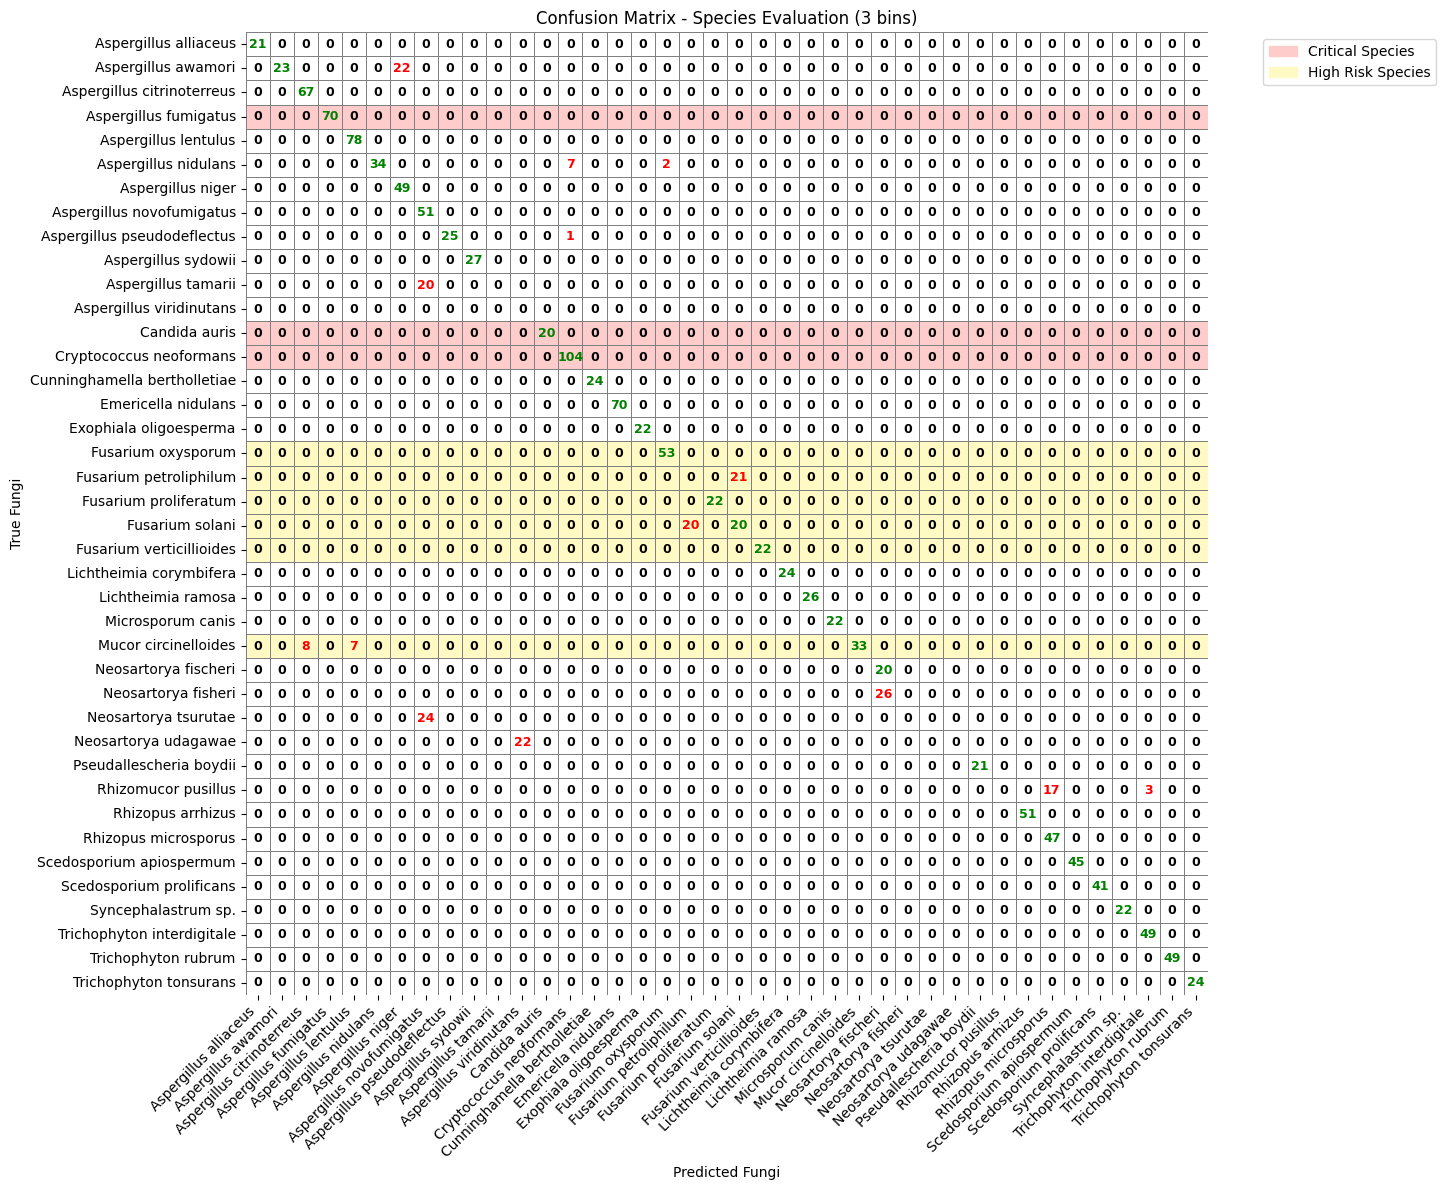

In [15]:
knn_species_result = evaluate_species_classifier(y_species_test, y_pred_species, critical_species_labels=critical_species_labels, high_risk_species_labels=high_risk_species_labels, class_names=species_list, title='Species Evaluation (3 bins)', highlight_background=True)

### Evaluación KNN de especies críticas


Critical Species Evaluation
Accuracy: 0.9604

Classification Report:
                             precision    recall  f1-score   support

      Aspergillus fumigatus       1.00      1.00      1.00        70
       Aspergillus nidulans       0.00      0.00      0.00         7
Aspergillus pseudodeflectus       0.00      0.00      0.00         1
              Candida auris       1.00      1.00      1.00        20
    Cryptococcus neoformans       0.93      1.00      0.96       104

                   accuracy                           0.96       202
                  macro avg       0.59      0.60      0.59       202
               weighted avg       0.92      0.96      0.94       202



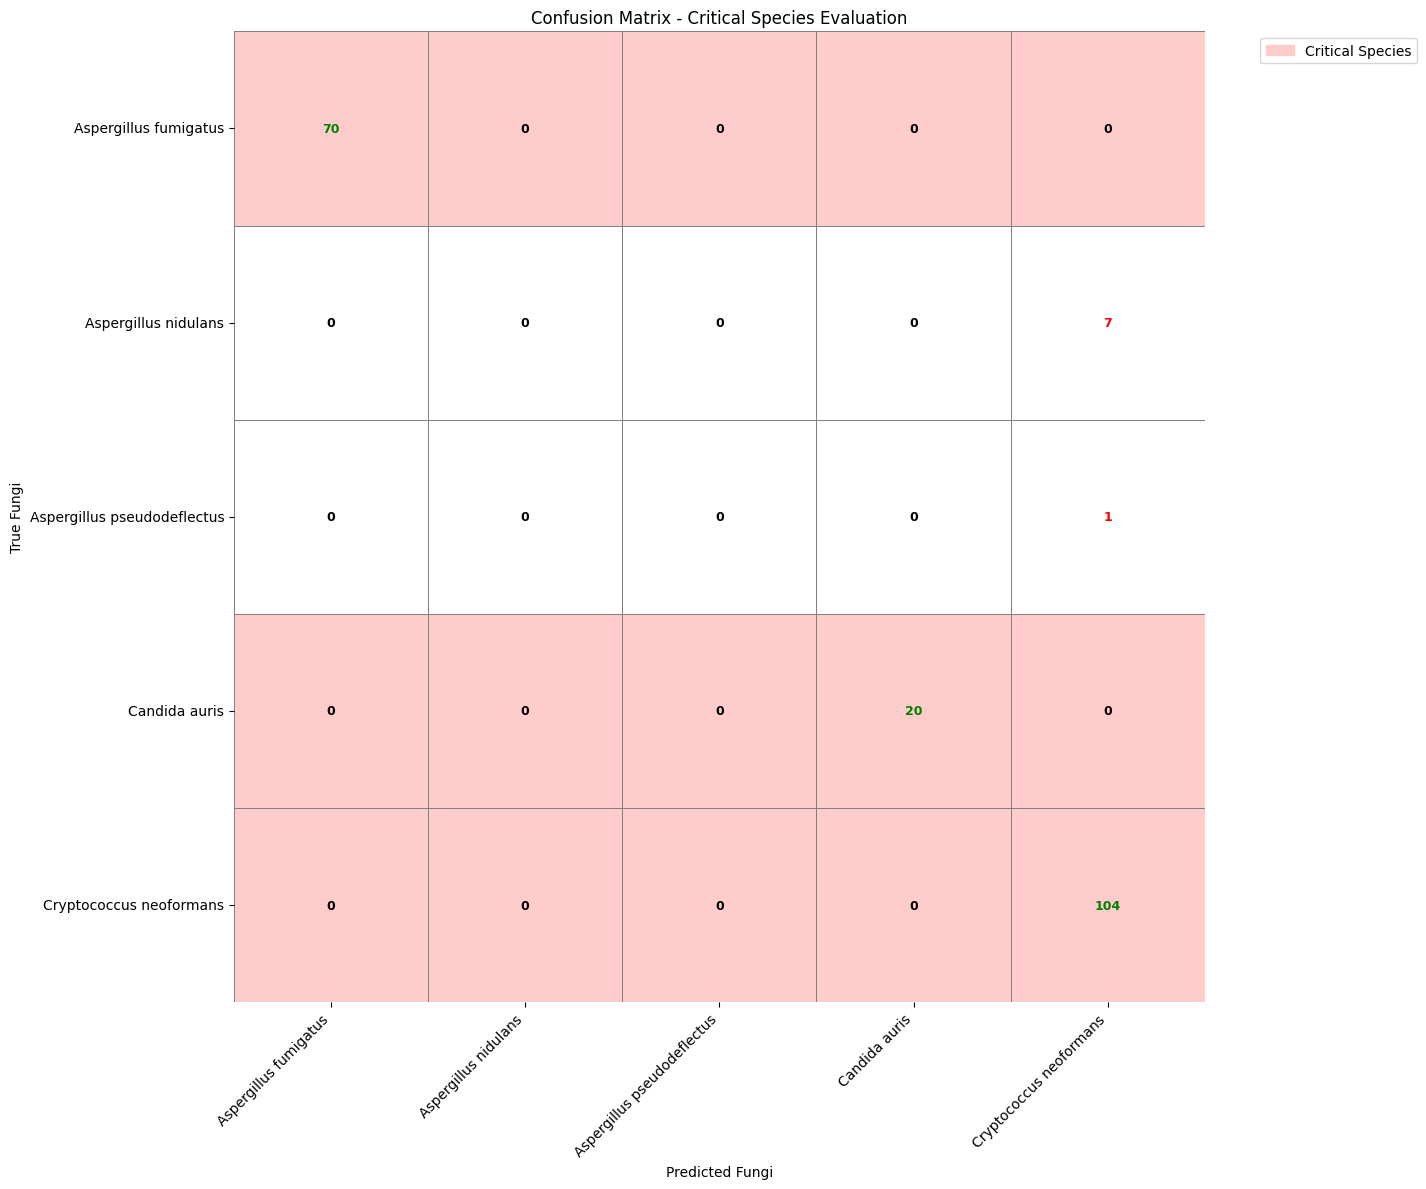

In [19]:
knn_critical_especies_results = evaluate_classifier_in_critical_species(y_species_test, y_pred_species, critical_species_labels=critical_species_labels, class_names=species_list)

### Evaluación KNN de especies de alto riesgo


High Risk Species Evaluation
Accuracy: 0.7212

Classification Report:
                            precision    recall  f1-score   support

Aspergillus citrinoterreus       0.00      0.00      0.00         0
      Aspergillus lentulus       0.00      0.00      0.00         0
      Aspergillus nidulans       0.00      0.00      0.00         2
        Fusarium oxysporum       0.96      1.00      0.98        53
    Fusarium petroliphilum       0.00      0.00      0.00        21
     Fusarium proliferatum       1.00      1.00      1.00        22
           Fusarium solani       0.49      0.50      0.49        40
  Fusarium verticillioides       1.00      1.00      1.00        22
      Mucor circinelloides       1.00      0.69      0.81        48

                  accuracy                           0.72       208
                 macro avg       0.49      0.47      0.48       208
              weighted avg       0.78      0.72      0.74       208



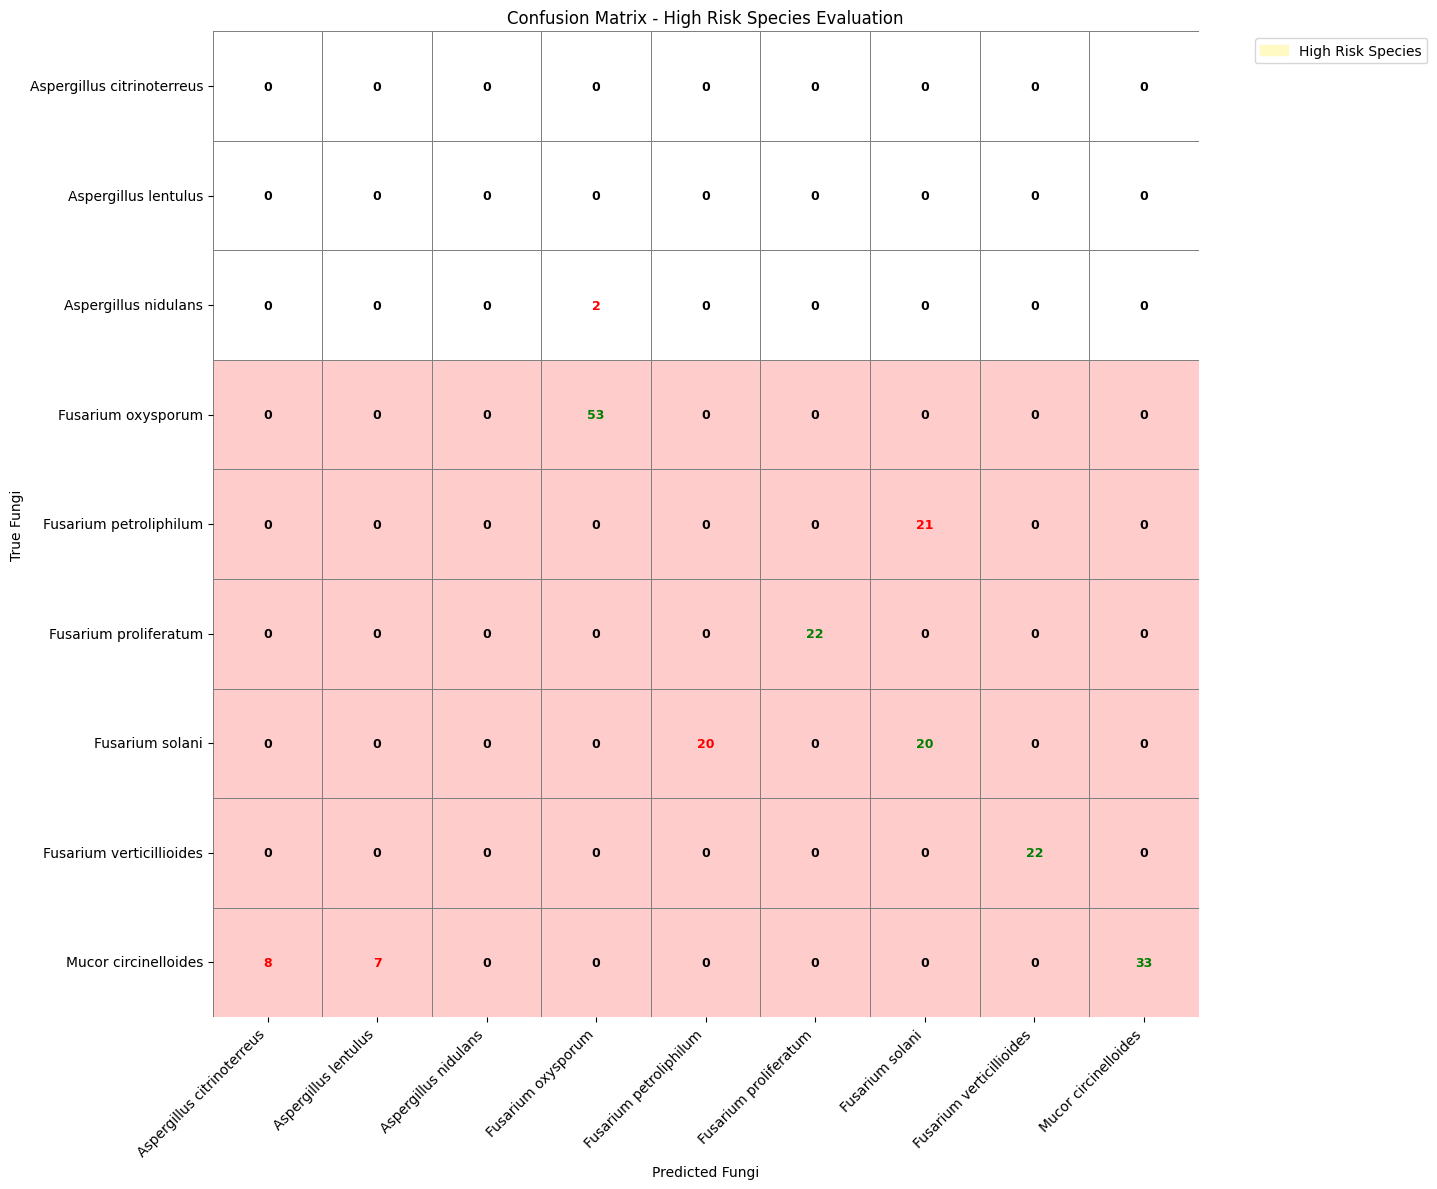

In [20]:
knn_high_species_results = evaluate_classifier_in_high_risk_species(y_species_test, y_pred_species, high_risk_species_labels=high_risk_species_labels, class_names=species_list)

## Evaluación de KNN a nivel de género

In [18]:
y_pred_genus = []

for i in y_pred_species:
    genus_species_str = species_list[i]
    genus_str = genus_species_str.split()[0]
    genus_label = label_encoder_genus.transform([genus_str])[0]
    y_pred_genus.append(genus_label)
y_pred_genus = np.array(y_pred_genus)

### Evaluación KNN global a nivel de género


Genus Evaluation (3 bins)
Accuracy: 0.9383

Classification Report:
                  precision    recall  f1-score   support

     Aspergillus       0.89      0.98      0.93       497
         Candida       1.00      1.00      1.00        20
    Cryptococcus       0.93      1.00      0.96       104
  Cunninghamella       1.00      1.00      1.00        24
      Emericella       1.00      1.00      1.00        70
       Exophiala       1.00      1.00      1.00        22
        Fusarium       0.99      1.00      0.99       158
     Lichtheimia       1.00      1.00      1.00        50
     Microsporum       1.00      1.00      1.00        22
           Mucor       1.00      0.69      0.81        48
     Neosartorya       1.00      0.50      0.67        92
Pseudallescheria       1.00      1.00      1.00        21
      Rhizomucor       0.00      0.00      0.00        20
        Rhizopus       0.85      1.00      0.92        98
    Scedosporium       1.00      1.00      1.00        86
 Sy

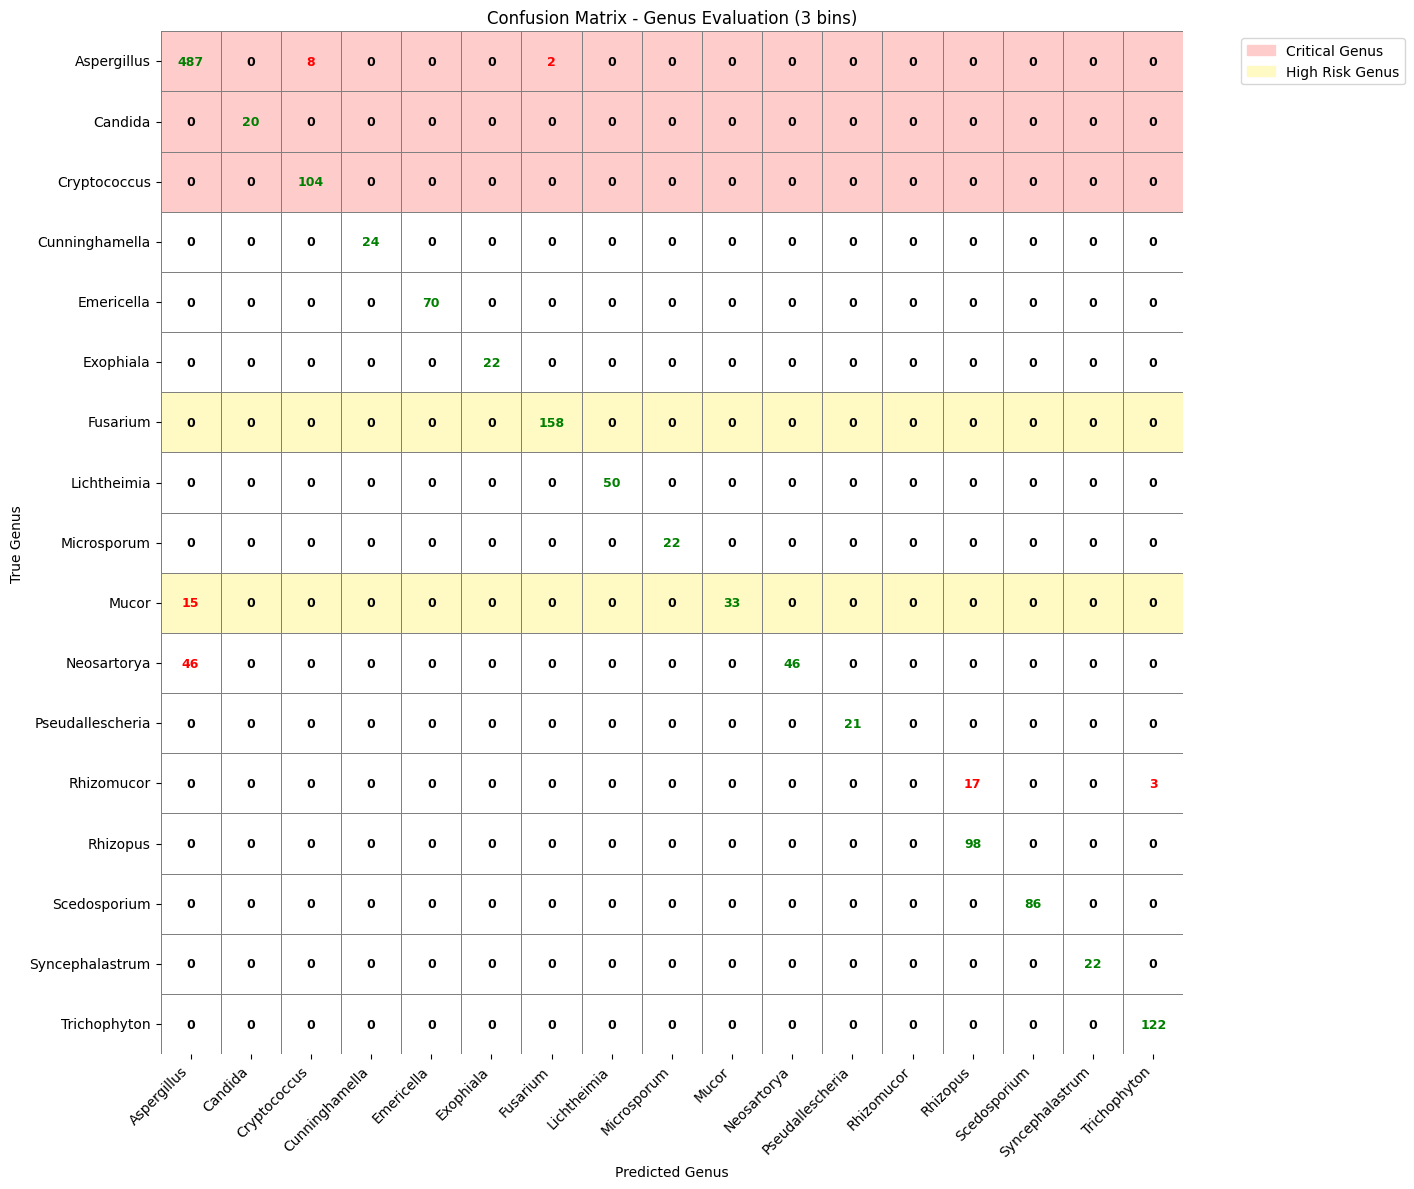

In [21]:
knn_genus_results = evaluate_genus_classifier(y_genus_test, y_pred_genus, critical_genus_labels=critical_genus_labels, high_risk_genus_labels=high_risk_genus_labels, class_names=genus_list, title='Genus Evaluation (3 bins)', highlight_background=True)

### Evaluación KNN de géneros críticos 


Critical Genus Evaluation
Accuracy: 0.8959

Classification Report:
              precision    recall  f1-score   support

 Aspergillus       0.89      0.98      0.93       497
     Candida       1.00      1.00      1.00        20
Cryptococcus       0.93      1.00      0.96       104
    Fusarium       0.00      0.00      0.00         0
       Mucor       0.00      0.00      0.00        15
 Neosartorya       0.00      0.00      0.00        46

    accuracy                           0.90       682
   macro avg       0.47      0.50      0.48       682
weighted avg       0.82      0.90      0.86       682



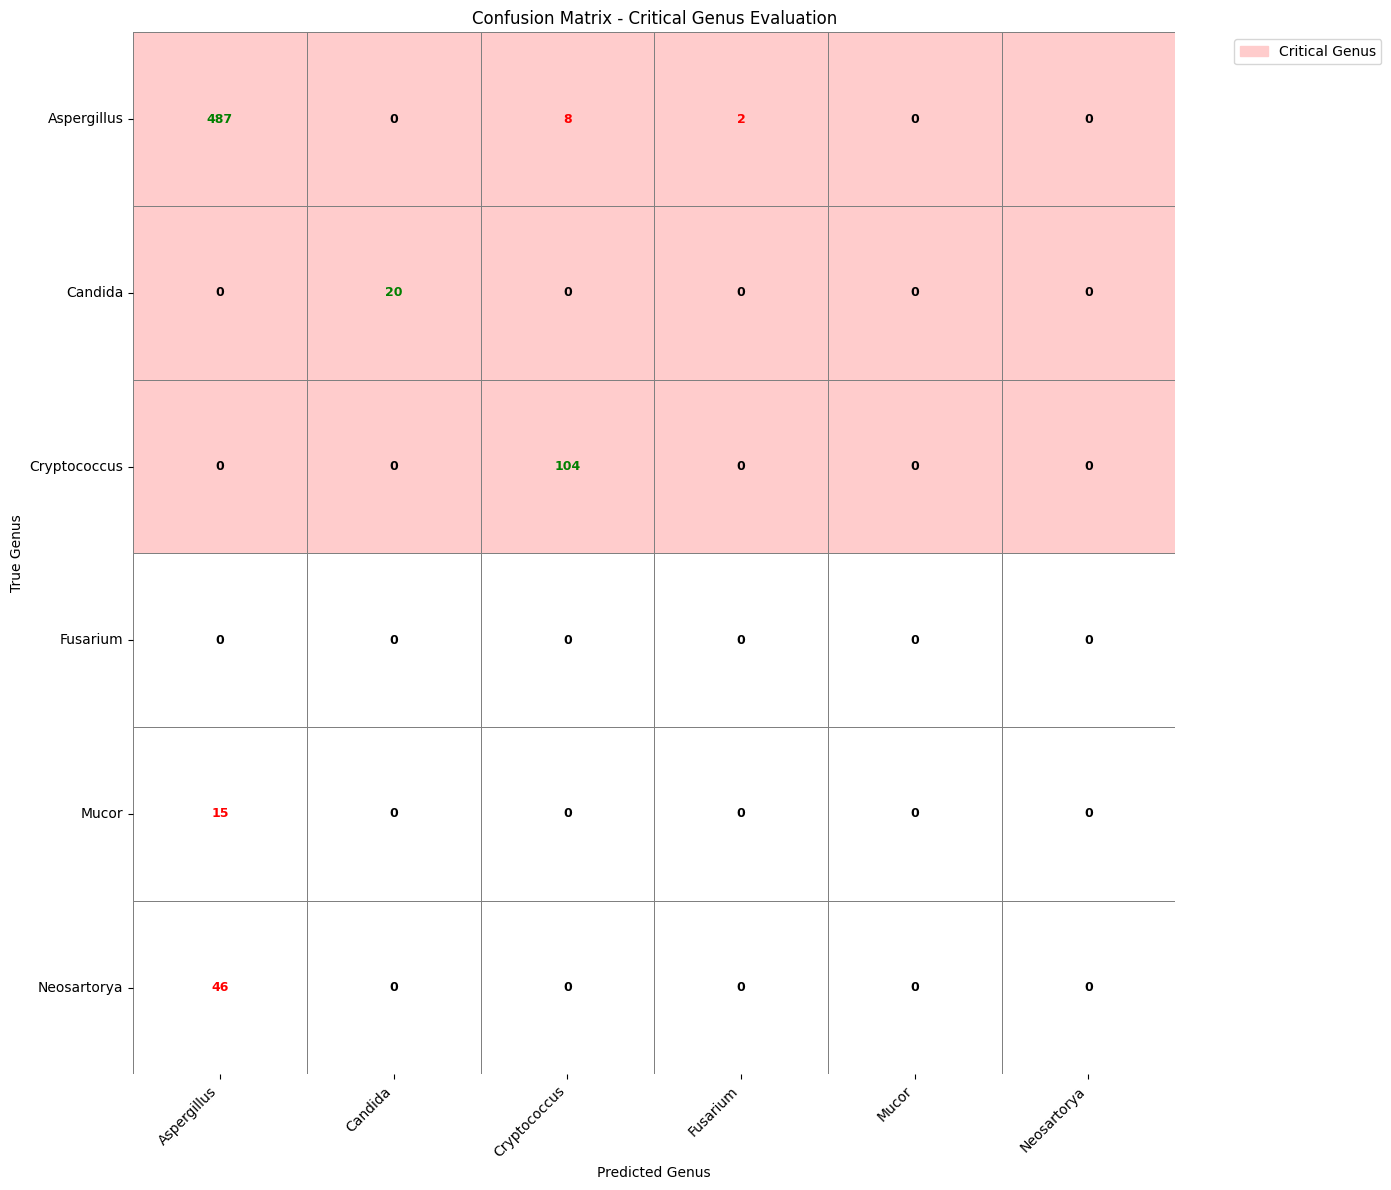

In [22]:
knn_critical_genus_results = evaluate_classifier_in_critical_genus(y_genus_test, y_pred_genus, critical_genus_labels=critical_genus_labels, class_names=genus_list)

### Evaluación KNN de géneros de alto riesgo


High Risk Genus Evaluation
Accuracy: 0.9183

Classification Report:
              precision    recall  f1-score   support

 Aspergillus       0.00      0.00      0.00         2
    Fusarium       0.99      1.00      0.99       158
       Mucor       1.00      0.69      0.81        48

    accuracy                           0.92       208
   macro avg       0.66      0.56      0.60       208
weighted avg       0.98      0.92      0.94       208



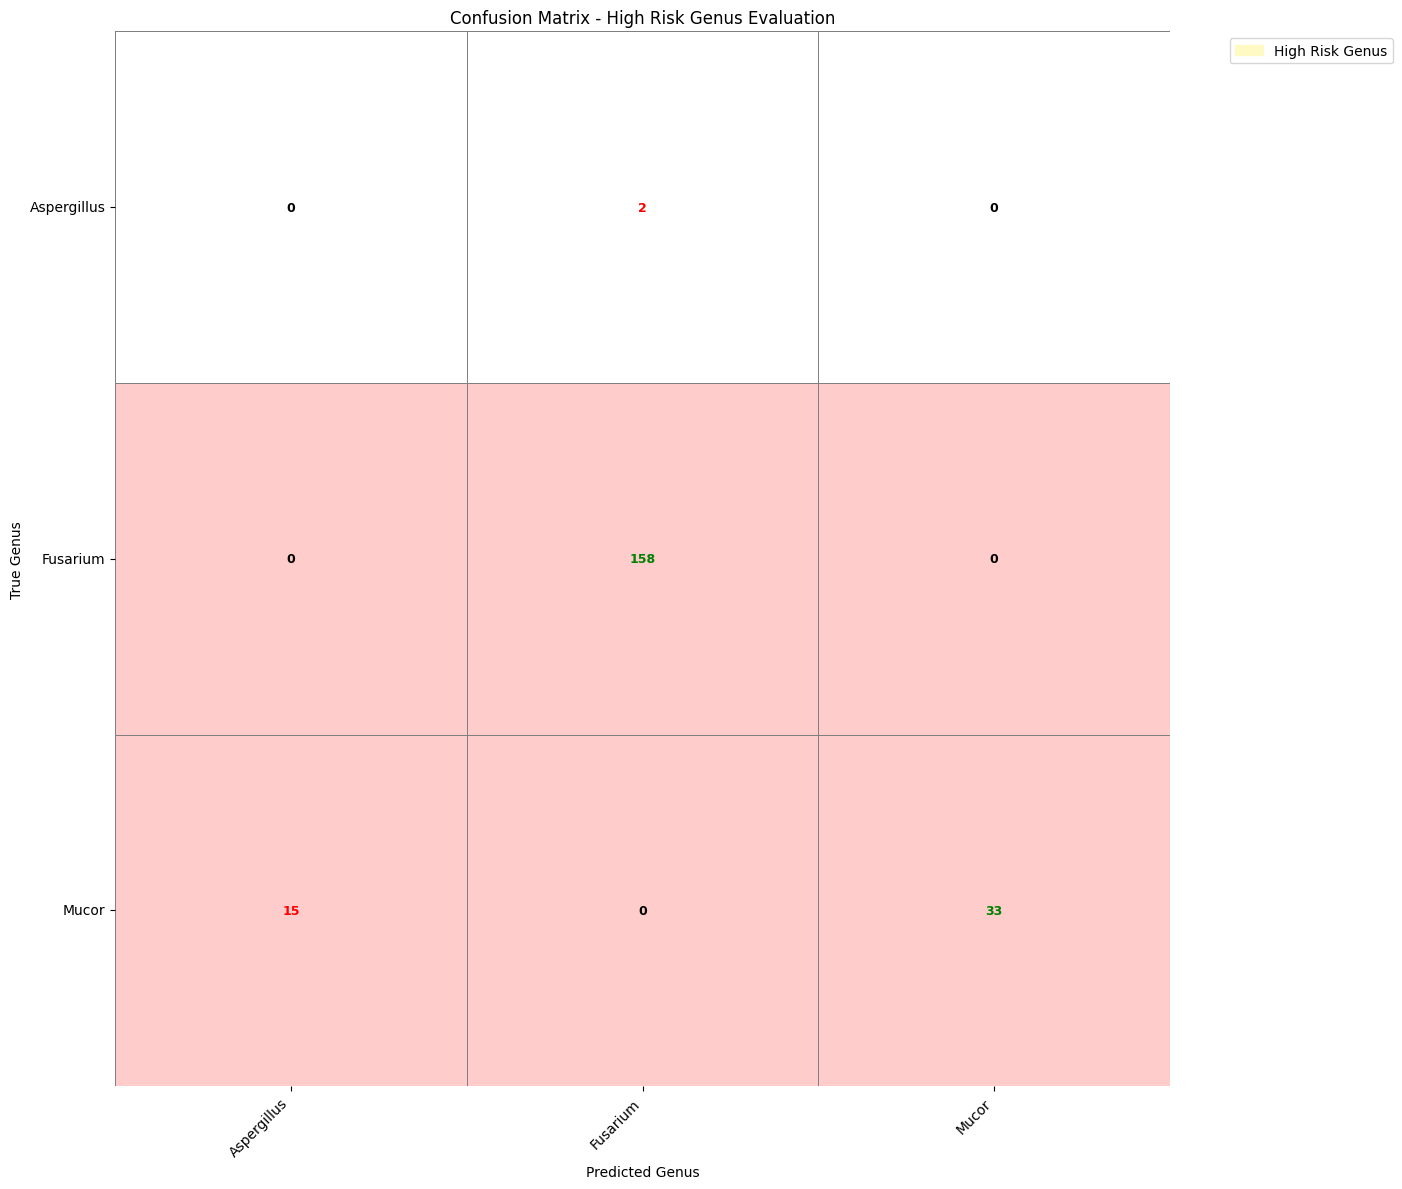

In [23]:
knn_high_genus_results = evaluate_classifier_in_high_risk_genus(y_genus_test, y_pred_genus, high_risk_genus_labels=high_risk_genus_labels, class_names=genus_list)

# Random Forest

## Evaluación Random Forest a nivel de género y especie

### Carga y entrenamiento del modelo Random Forest

In [24]:
# Cargar el pipeline de Random Forest con 3 bins
rf_pipeline = joblib.load('bin_3_models_pipelines/3_bin_rf_pipeline.pkl')

rf_pipeline.fit(x_train, y_species_train)
rf_pred_species = rf_pipeline.predict(x_test)

### Evaluación Random Forest global a nivel de género y especie


Random Forest Species Evaluation (3 bins)
Accuracy: 0.8645

Classification Report:
                              precision    recall  f1-score   support

       Aspergillus alliaceus       1.00      1.00      1.00        21
         Aspergillus awamori       1.00      0.51      0.68        45
  Aspergillus citrinoterreus       0.89      1.00      0.94        67
       Aspergillus fumigatus       1.00      1.00      1.00        70
        Aspergillus lentulus       0.92      1.00      0.96        78
        Aspergillus nidulans       1.00      0.79      0.88        43
           Aspergillus niger       0.69      1.00      0.82        49
   Aspergillus novofumigatus       0.54      1.00      0.70        51
 Aspergillus pseudodeflectus       1.00      0.96      0.98        26
         Aspergillus sydowii       1.00      1.00      1.00        27
         Aspergillus tamarii       0.00      0.00      0.00        20
    Aspergillus viridinutans       0.00      0.00      0.00         0
     

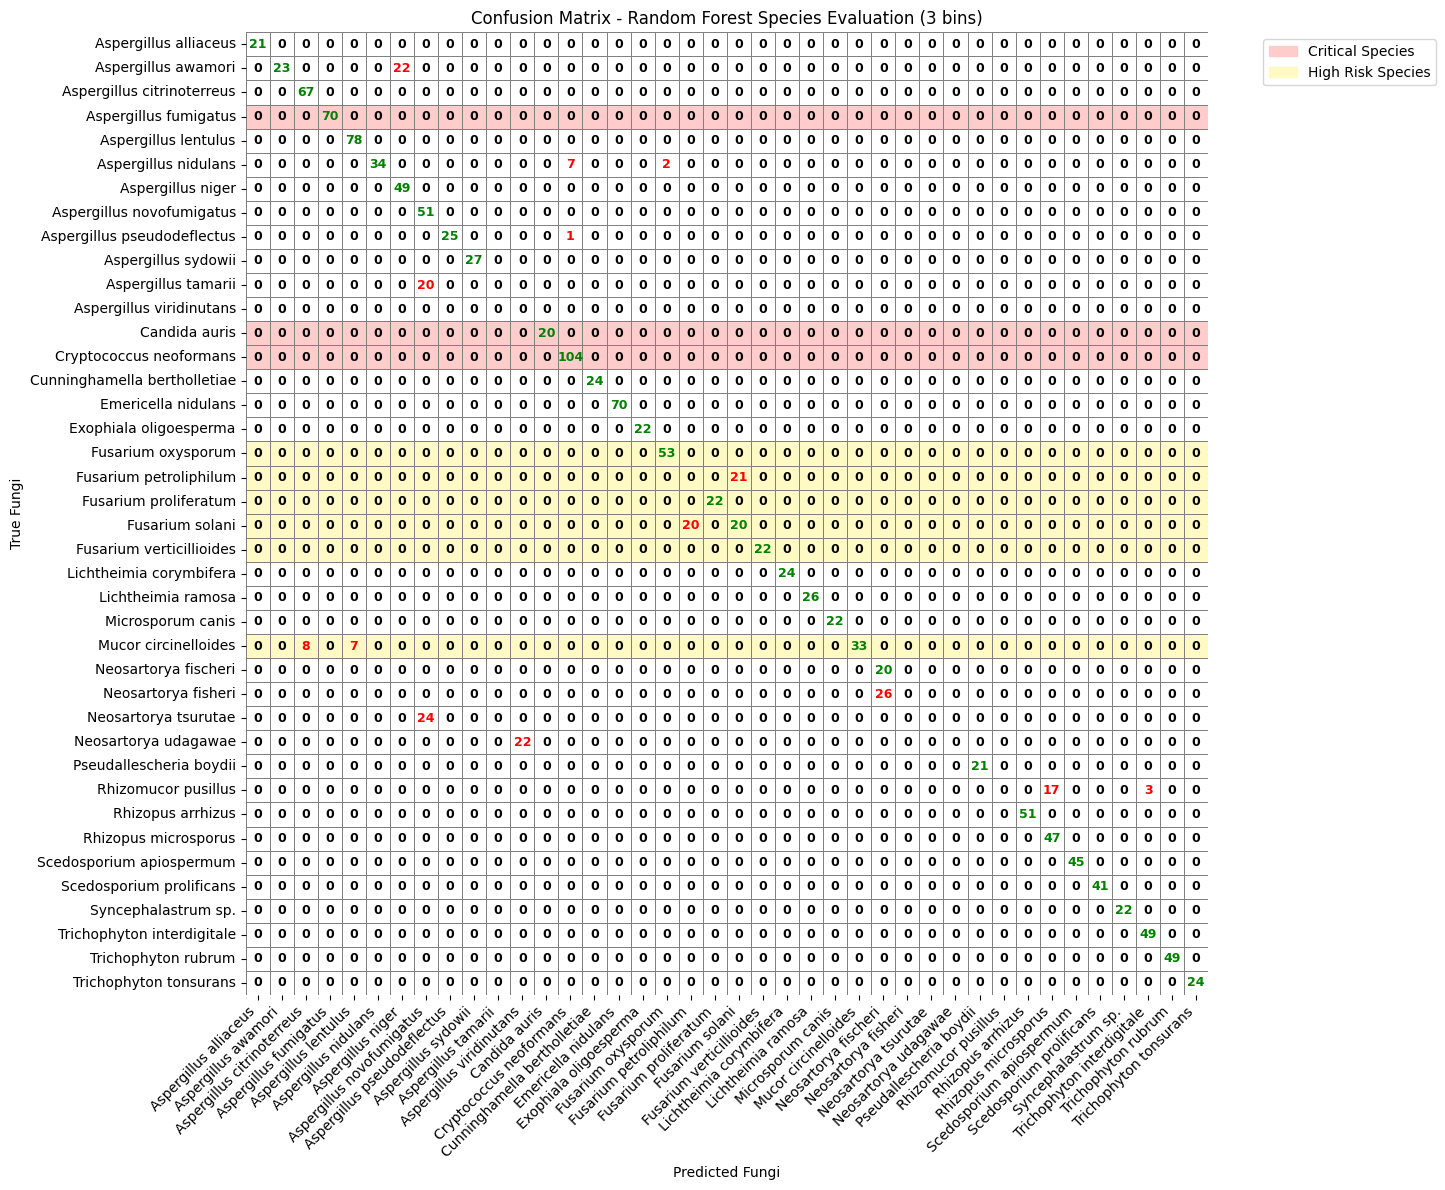

In [25]:
rf_species_result = evaluate_species_classifier(y_species_test, rf_pred_species, critical_species_labels=critical_species_labels, high_risk_species_labels=high_risk_species_labels, class_names=species_list, title='Random Forest Species Evaluation (3 bins)', highlight_background=True)

### Evaluación Random Forest de especies críticas


Critical Species Evaluation
Accuracy: 0.9604

Classification Report:
                             precision    recall  f1-score   support

      Aspergillus fumigatus       1.00      1.00      1.00        70
       Aspergillus nidulans       0.00      0.00      0.00         7
Aspergillus pseudodeflectus       0.00      0.00      0.00         1
              Candida auris       1.00      1.00      1.00        20
    Cryptococcus neoformans       0.93      1.00      0.96       104

                   accuracy                           0.96       202
                  macro avg       0.59      0.60      0.59       202
               weighted avg       0.92      0.96      0.94       202



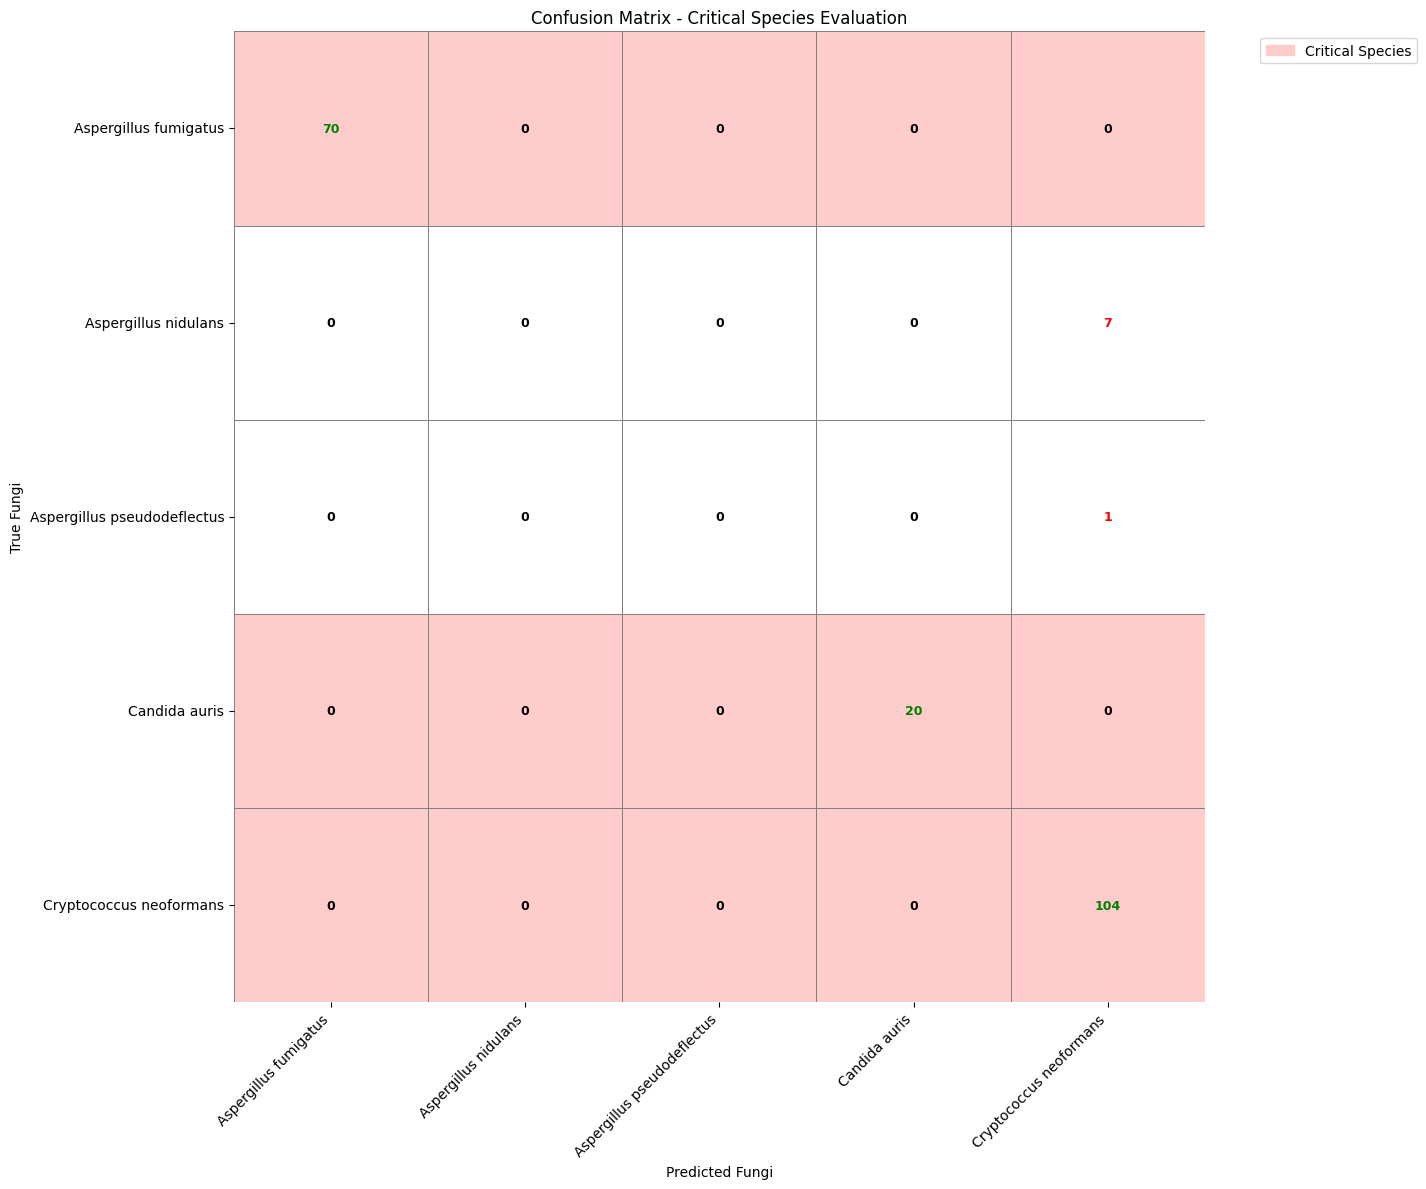

In [26]:
rf_critical_especies_results = evaluate_classifier_in_critical_species(y_species_test, rf_pred_species, critical_species_labels=critical_species_labels, class_names=species_list)

### Evaluación Random Forest de especies de alto riesgo


High Risk Species Evaluation
Accuracy: 0.7212

Classification Report:
                            precision    recall  f1-score   support

Aspergillus citrinoterreus       0.00      0.00      0.00         0
      Aspergillus lentulus       0.00      0.00      0.00         0
      Aspergillus nidulans       0.00      0.00      0.00         2
        Fusarium oxysporum       0.96      1.00      0.98        53
    Fusarium petroliphilum       0.00      0.00      0.00        21
     Fusarium proliferatum       1.00      1.00      1.00        22
           Fusarium solani       0.49      0.50      0.49        40
  Fusarium verticillioides       1.00      1.00      1.00        22
      Mucor circinelloides       1.00      0.69      0.81        48

                  accuracy                           0.72       208
                 macro avg       0.49      0.47      0.48       208
              weighted avg       0.78      0.72      0.74       208



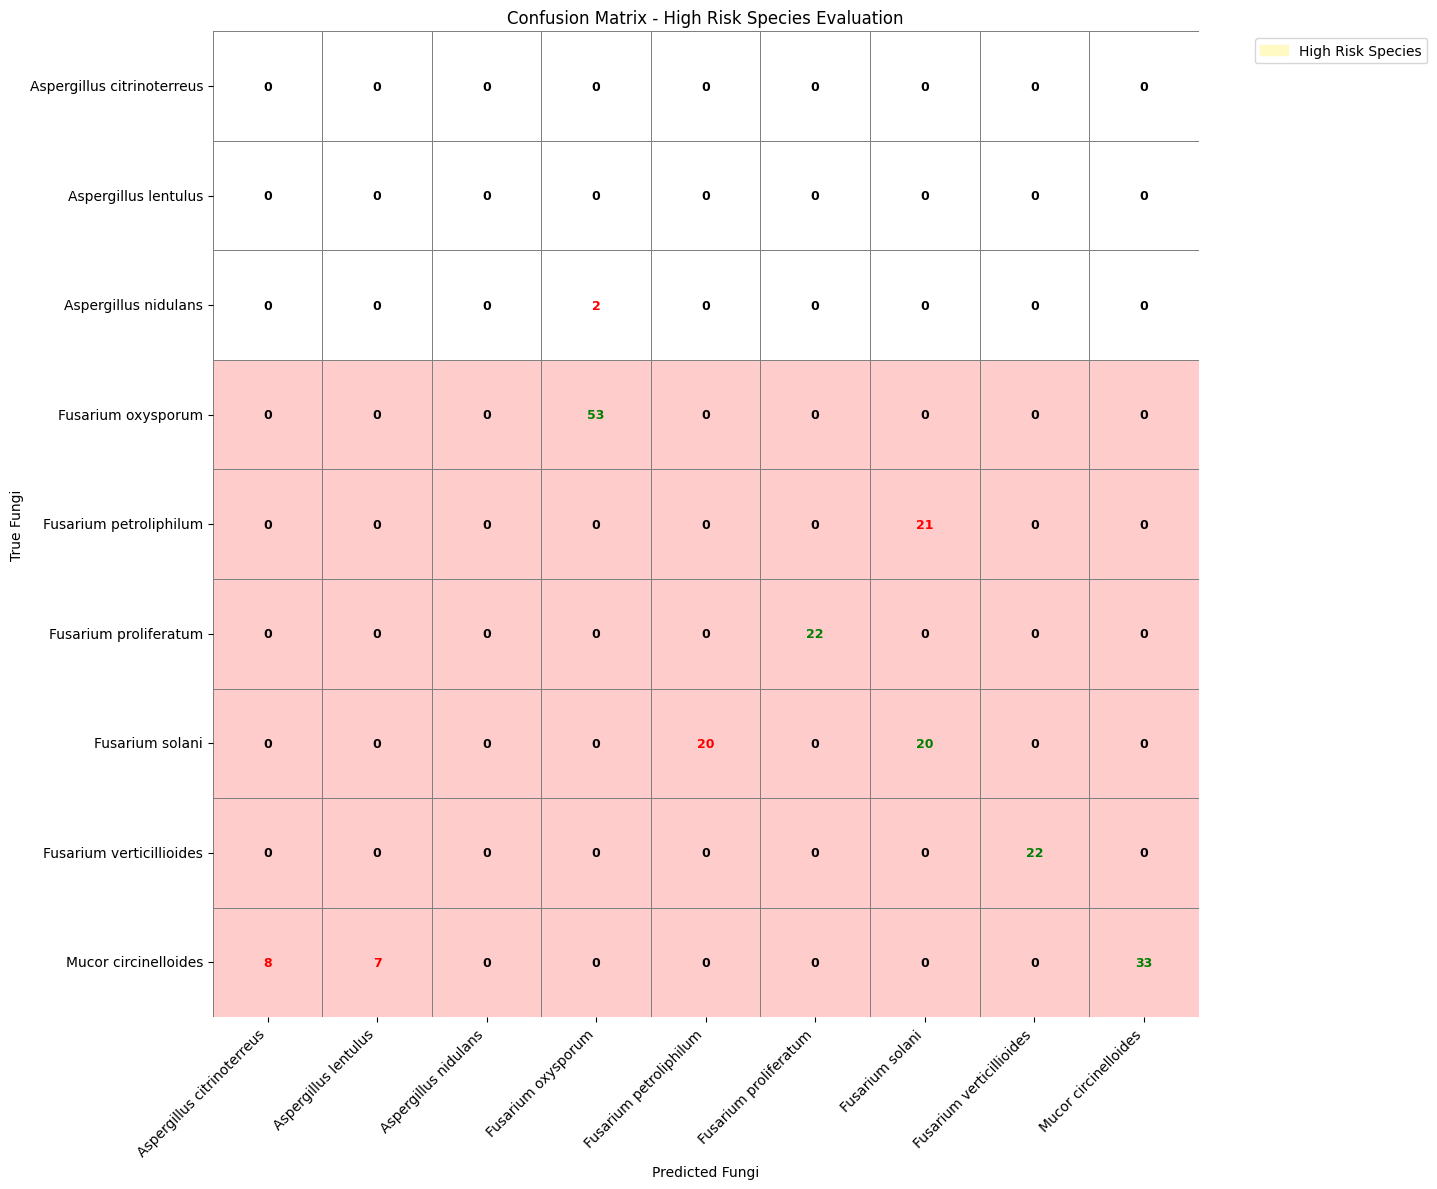

In [27]:
rf_high_species_results = evaluate_classifier_in_high_risk_species(y_species_test, rf_pred_species, high_risk_species_labels=high_risk_species_labels, class_names=species_list)

## Evaluación de Random Forest a nivel de género

In [28]:
rf_pred_genus = []

for i in rf_pred_species:
    genus_species_str = species_list[i]
    genus_str = genus_species_str.split()[0]
    genus_label = label_encoder_genus.transform([genus_str])[0]
    rf_pred_genus.append(genus_label)
rf_pred_genus = np.array(rf_pred_genus)

### Evaluación Random Forest global a nivel de género


Random Forest Genus Evaluation (3 bins)
Accuracy: 0.9383

Classification Report:
                  precision    recall  f1-score   support

     Aspergillus       0.89      0.98      0.93       497
         Candida       1.00      1.00      1.00        20
    Cryptococcus       0.93      1.00      0.96       104
  Cunninghamella       1.00      1.00      1.00        24
      Emericella       1.00      1.00      1.00        70
       Exophiala       1.00      1.00      1.00        22
        Fusarium       0.99      1.00      0.99       158
     Lichtheimia       1.00      1.00      1.00        50
     Microsporum       1.00      1.00      1.00        22
           Mucor       1.00      0.69      0.81        48
     Neosartorya       1.00      0.50      0.67        92
Pseudallescheria       1.00      1.00      1.00        21
      Rhizomucor       0.00      0.00      0.00        20
        Rhizopus       0.85      1.00      0.92        98
    Scedosporium       1.00      1.00      1.00

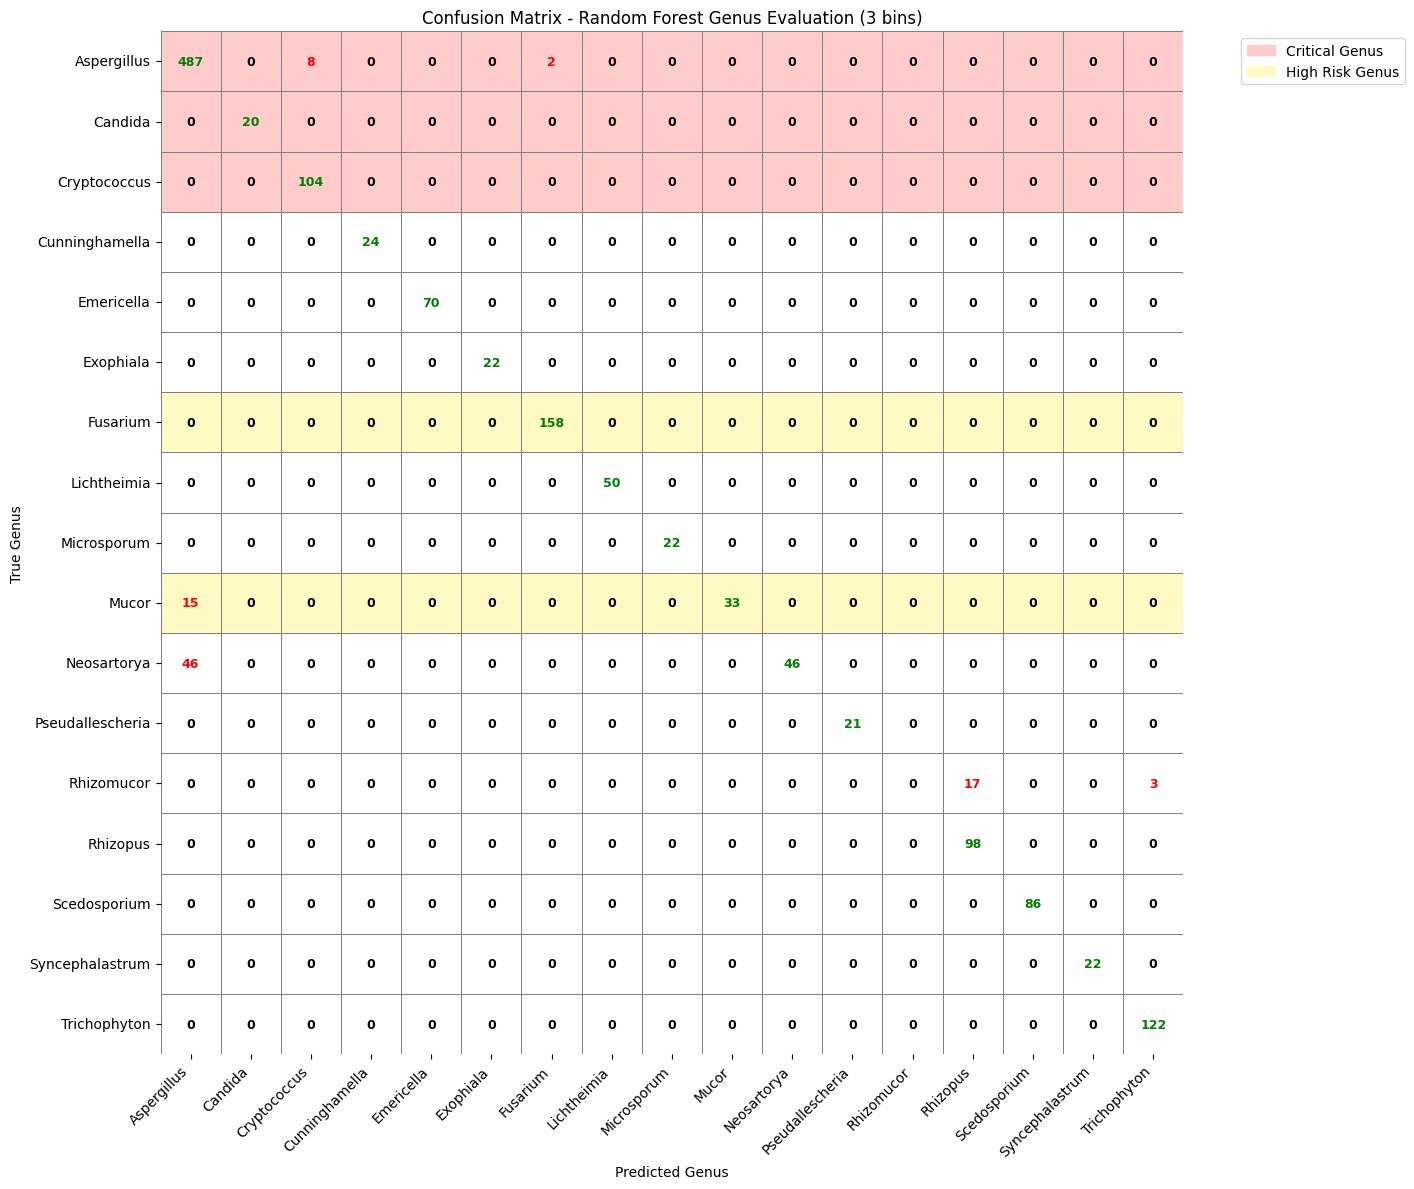

In [29]:
rf_genus_results = evaluate_genus_classifier(y_genus_test, rf_pred_genus, critical_genus_labels=critical_genus_labels, high_risk_genus_labels=high_risk_genus_labels, class_names=genus_list, title='Random Forest Genus Evaluation (3 bins)', highlight_background=True)

### Evaluación Random Forest de géneros críticos


Critical Genus Evaluation
Accuracy: 0.8959

Classification Report:
              precision    recall  f1-score   support

 Aspergillus       0.89      0.98      0.93       497
     Candida       1.00      1.00      1.00        20
Cryptococcus       0.93      1.00      0.96       104
    Fusarium       0.00      0.00      0.00         0
       Mucor       0.00      0.00      0.00        15
 Neosartorya       0.00      0.00      0.00        46

    accuracy                           0.90       682
   macro avg       0.47      0.50      0.48       682
weighted avg       0.82      0.90      0.86       682



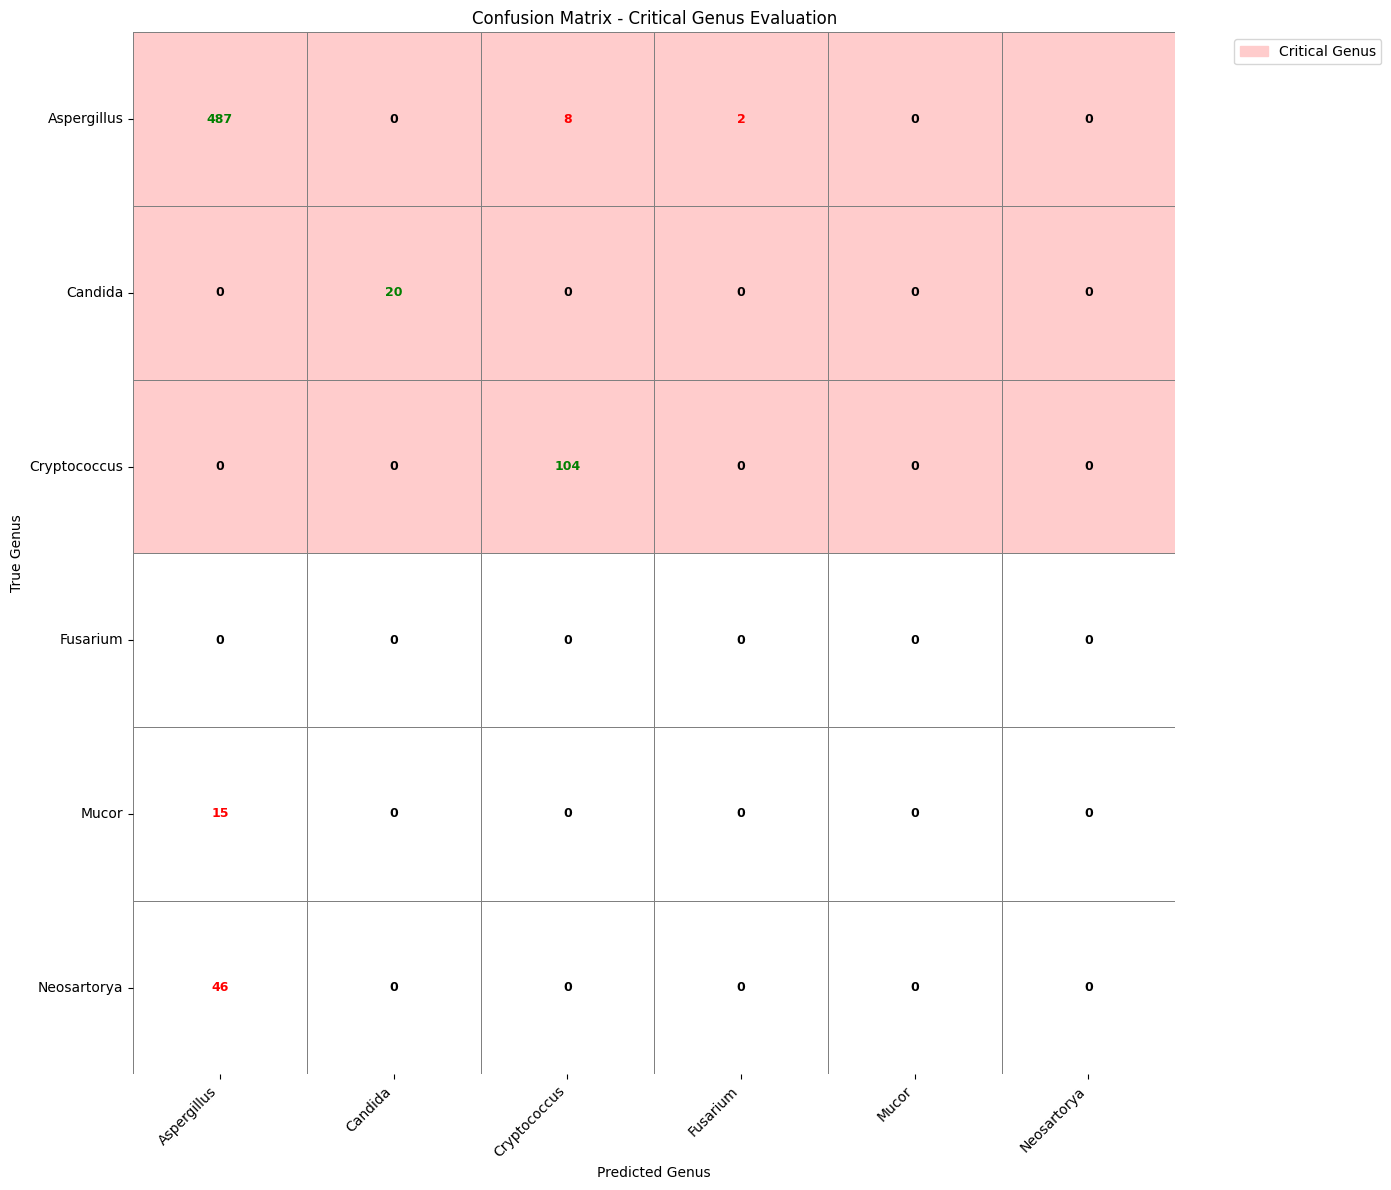

In [30]:
rf_critical_genus_results = evaluate_classifier_in_critical_genus(y_genus_test, rf_pred_genus, critical_genus_labels=critical_genus_labels, class_names=genus_list)

### Evaluación Random Forest de géneros de alto riesgo


High Risk Genus Evaluation
Accuracy: 0.9183

Classification Report:
              precision    recall  f1-score   support

 Aspergillus       0.00      0.00      0.00         2
    Fusarium       0.99      1.00      0.99       158
       Mucor       1.00      0.69      0.81        48

    accuracy                           0.92       208
   macro avg       0.66      0.56      0.60       208
weighted avg       0.98      0.92      0.94       208



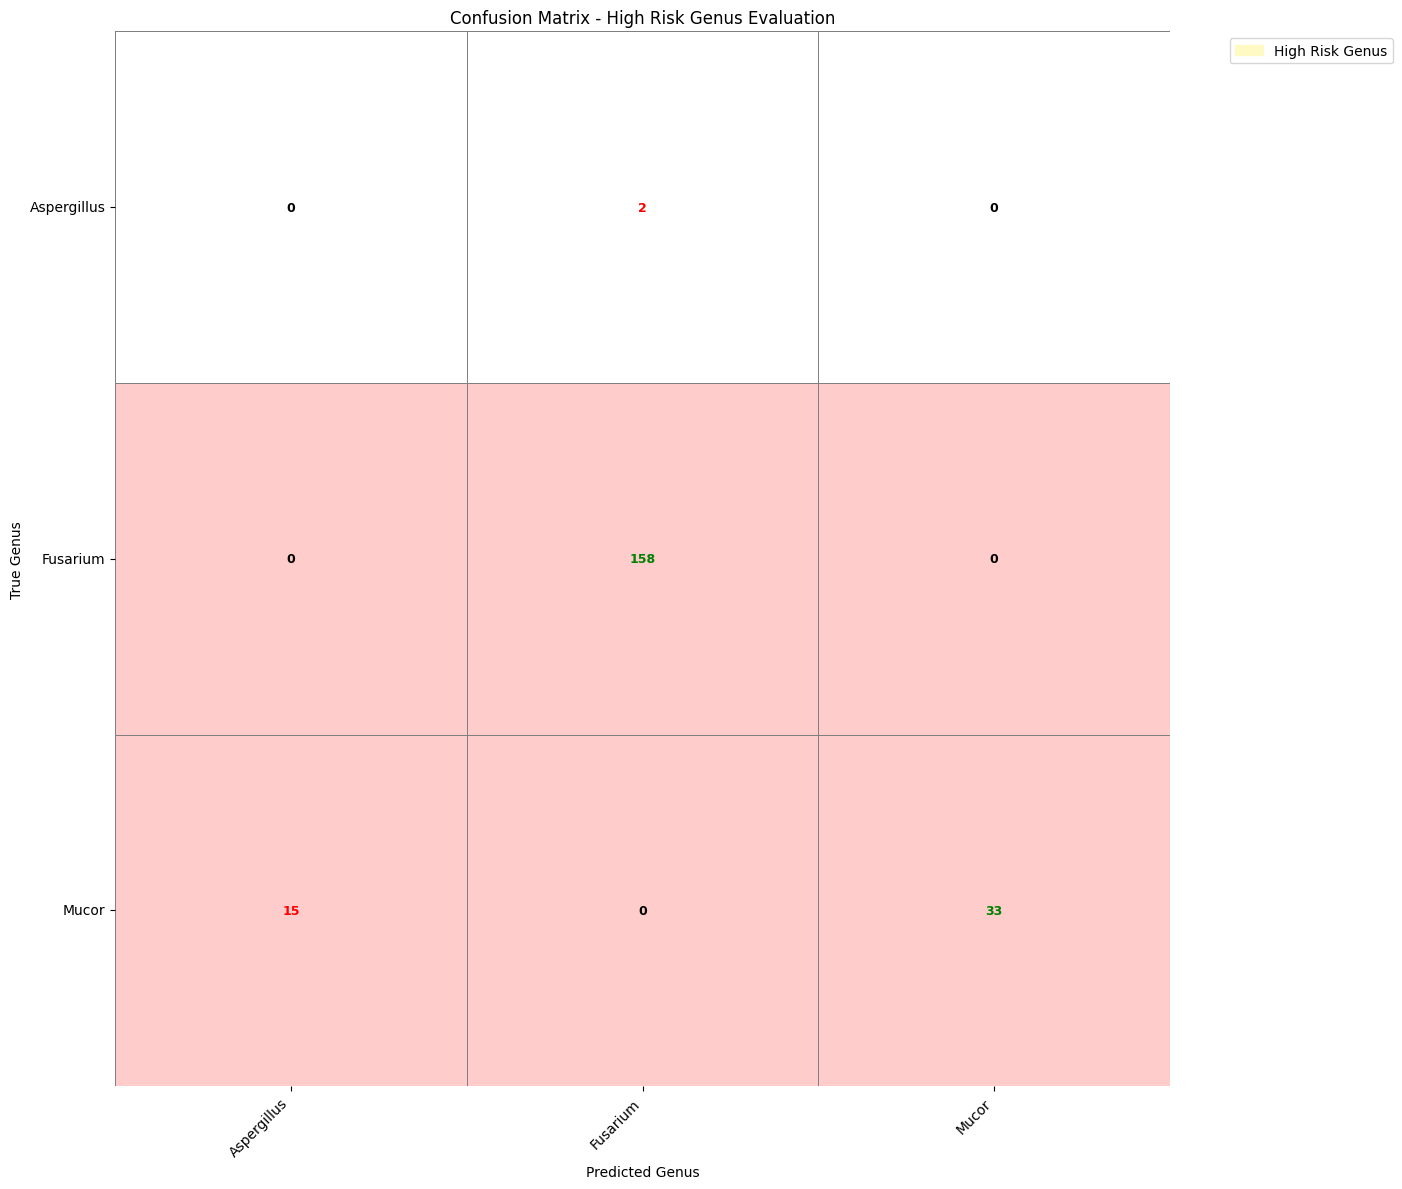

In [31]:
rf_high_genus_results = evaluate_classifier_in_high_risk_genus(y_genus_test, rf_pred_genus, high_risk_genus_labels=high_risk_genus_labels, class_names=genus_list)